# 1. Overview
## Project Detail
><p>Dalam dataset studi kasus ini</a>, kita memiliki pembacaan suhu dari perangkat IoT yang dipasang di luar dan di dalam ruangan anonim. Karena perangkat sedang dalam tahap pengujian, perangkat tersebut dicopot pemasangannya atau dimatikan beberapa kali selama seluruh periode pembacaan, sehingga menyebabkan beberapa outlier dan nilai yang hilang.</p><br/>
>Dataset detail:
><ul>
>    <li><b>id</b> : ID unik untuk setiap pembacaan</li>
>    <li><b>room_id/id</b> : id ruangan tempat perangkat dipasang (saat ini 'ruang admin' hanya untuk tujuan contoh).</li>
>    <li><b>noted_date</b> : tanggal dan waktu membaca</li>
>    <li><b>temp</b> : pembacaan suhu</li>
>    <li><b>out/in</b> : apakah pembacaan diambil dari perangkat yang dipasang di dalam atau di luar ruangan</li>
></ul>
>dari dataset ini Kita dapat mencari tahu hal berikut:
><ul>
>    <li>hubungan suhu dalam dan luar</li>
>    <li>tren atau musiman dalam data</li>
>    <li>meramalkan suhu masa depan dengan menggunakan pemodelan deret waktu</li>
>    <li>kecenderungan karakteristik sepanjang tahun, bulan, minggu atau siang/malam</li>
>    <li>dan seterusnya...</li>
></ul>



<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>

# 2. Import libraries Praproses

In [ ]:
import numpy as np
import pandas as pd

<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>

# 3. Load the dataset

In [ ]:
df = pd.read_csv("IOT-temp.csv")
print(f'IOT-temp.csv : {df.shape}')
df.head(3)

IOT-temp.csv : (97606, 5)


,id,room_id/id,noted_date,temp,out/in
0,__export__.temp_log_196134_bd201015,Room Admin,8/12/18 9:30,29,In
1,__export__.temp_log_196131_7bca51bc,Room Admin,8/12/18 9:30,29,In
2,__export__.temp_log_196127_522915e3,Room Admin,8/12/18 9:29,41,Out


<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>

# 4. Pre-processing

>kolom 'room_id/id' hanya mempunyai satu nilai (Room Admin), jadi kita tidak memerlukan kolom ini untuk analisis.

In [ ]:
df['room_id/id'].value_counts()

Room Admin    97606
Name: room_id/id, dtype: int64

In [ ]:
df.drop('room_id/id', axis=1, inplace=True)
df.head(3)

,id,noted_date,temp,out/in
0,__export__.temp_log_196134_bd201015,8/12/18 9:30,29,In
1,__export__.temp_log_196131_7bca51bc,8/12/18 9:30,29,In
2,__export__.temp_log_196127_522915e3,8/12/18 9:29,41,Out


>mengubah nama kolom agar mudah dipahami

In [ ]:
df.rename(columns={'noted_date':'date', 'out/in':'place'}, inplace=True)
df.head(3)

,id,date,temp,place
0,__export__.temp_log_196134_bd201015,8/12/18 9:30,29,In
1,__export__.temp_log_196131_7bca51bc,8/12/18 9:30,29,In
2,__export__.temp_log_196127_522915e3,8/12/18 9:29,41,Out


<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>

## Informasi tanggal dan waktu
>kolom datetime berisi banyak informasi seperti tahun, bulan, hari kerja dan lain sebagainya. Untuk memanfaatkan informasi ini dalam fase EDA dan pemodelan, kita perlu mengekstraknya dari kolom datetime.

In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%y %H:%M', errors='coerce')
df['year'] = df['date'].apply(lambda x: x.year)
df['month'] = df['date'].apply(lambda x: x.month)
df['day'] = df['date'].apply(lambda x: x.day)
df['weekday'] = df['date'].apply(lambda x: x.day_name())
df['weekofyear'] = df['date'].apply(lambda x: x.weekofyear)
df['hour'] = df['date'].apply(lambda x: x.hour)
df['minute'] = df['date'].apply(lambda x: x.minute)

<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>

## Seasonal information
><div class="alert alert-success" role="alert">
>Anggap data ini dikumpulkan di Indonesia.<br/>
>Indonesia mempunyai dua musim klimatologi seperti di bawah ini.
><ul>
>    <li><b>Rainy</b> : October to March</li>
>    <li><b>Dry</b> : April to September</li>
>  
></ul>
></div>

>function to convert month variable into seasons

In [ ]:
def month2seasons(x):
    season = ''

    if x in [10, 11, 12, 1, 2, 3]:
        season = 'Rainy'
    elif x in [4, 5, 6, 7, 8, 9]:
        season = 'Dry'

    return season


In [ ]:
df['season'] = df['month'].apply(month2seasons)
df.head(3)

,id,date,temp,place,year,month,day,weekday,weekofyear,hour,minute,season
0,__export__.temp_log_196134_bd201015,2018-12-08 09:30:00,29,In,2018.0,12.0,8.0,Saturday,49.0,9.0,30.0,Rainy
1,__export__.temp_log_196131_7bca51bc,2018-12-08 09:30:00,29,In,2018.0,12.0,8.0,Saturday,49.0,9.0,30.0,Rainy
2,__export__.temp_log_196127_522915e3,2018-12-08 09:29:00,41,Out,2018.0,12.0,8.0,Saturday,49.0,9.0,29.0,Rainy


<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>

## Informasi waktu
><div class="alert alert-success" role="alert">
>Variabel jam dapat dipecah menjadi Malam, Pagi, Siang dan Malam berdasarkan nomornya.
><ul>
> <li><b>Malam</b> : 22:00 - 23:59 / 00:00 - 03:59</li>
> <li><b>Pagi</b> : 04:00 - 11:59</li>
> <li><b>Sore</b> : 12:00 - 16:59</li>
> <li><b>Malam</b> : 17:00 - 21:59</li>
></ul>
>Kita dapat membuat variabel waktu berdasarkan variabel jam.<br/>
><u>Idenya datang dari <a href='https://www.kaggle.com/satishkundanagar/temp-reading-iot-devices-eda'>buku catatan ini.</a></u>
></div>

In [ ]:
def hours2timing(x):
    if x in [22,23,0,1,2,3]:
        timing = 'Night'
    elif x in range(4, 12):
        timing = 'Morning'
    elif x in range(12, 17):
        timing = 'Afternoon'
    elif x in range(17, 22):
        timing = 'Evening'
    else:
        timing = 'X'
    return timing

In [ ]:
df['timing'] = df['hour'].apply(hours2timing)
df.head(3)

,id,date,temp,place,year,month,day,weekday,weekofyear,hour,minute,season,timing
0,__export__.temp_log_196134_bd201015,2018-12-08 09:30:00,29,In,2018.0,12.0,8.0,Saturday,49.0,9.0,30.0,Rainy,Morning
1,__export__.temp_log_196131_7bca51bc,2018-12-08 09:30:00,29,In,2018.0,12.0,8.0,Saturday,49.0,9.0,30.0,Rainy,Morning
2,__export__.temp_log_196127_522915e3,2018-12-08 09:29:00,41,Out,2018.0,12.0,8.0,Saturday,49.0,9.0,29.0,Rainy,Morning


<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>

## Pengidentifikasi unik ditentukan oleh id
><div class="alert alert-success" role="alert">
>Kolom 'id' sepertinya memiliki beberapa informasi terkait kolom 'tanggal'. <br/>
>Kolom 'tanggal' tidak memiliki informasi detik, jadi 'id' mungkin memiliki informasi detik atau keunikan kapan data dikumpulkan.<br/>


### Duplikasi
>Setelah dicek apakah ada record yang terduplikasi, ternyata ada record yang duplikat. Jadi kita perlu memasukkan catatan duplikat ke dalam satu catatan unik.

In [ ]:
df[df.duplicated()]

,id,date,temp,place,year,month,day,weekday,weekofyear,hour,minute,season,timing
11,__export__.temp_log_196108_4a983c7e,2018-12-08 09:25:00,42,Out,2018.0,12.0,8.0,Saturday,49.0,9.0,25.0,Rainy,Morning


In [ ]:
df[df['id']=='__export__.temp_log_196108_4a983c7e']

,id,date,temp,place,year,month,day,weekday,weekofyear,hour,minute,season,timing
10,__export__.temp_log_196108_4a983c7e,2018-12-08 09:25:00,42,Out,2018.0,12.0,8.0,Saturday,49.0,9.0,25.0,Rainy,Morning
11,__export__.temp_log_196108_4a983c7e,2018-12-08 09:25:00,42,Out,2018.0,12.0,8.0,Saturday,49.0,9.0,25.0,Rainy,Morning


In [ ]:
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,id,date,temp,place,year,month,day,weekday,weekofyear,hour,minute,season,timing


<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>

### Keunikan id
><div class="alert alert-success" role="alert">
>Melihat lebih dekat pada kolom 'id', sepertinya kolom tersebut memiliki nilai unik dan dua komponen yang dapat didekomposisi, numerik dan alfanumerik.<br/>
>Dalam kasus 'id' <b>'__export__.temp_log_101144_ff2f0b97'</b>, dapat dipecah menjadi dua bagian.
><ul>
> <li><b>bagian numerik</b> : 101144</li>
> <li><b>bagian alfanumerik</b> : ff2f0b97</li>
></ul>
>Bagian alfa-numerik terlihat mustahil untuk dipahami, namun <u>bagian numerik dapat menunjukkan <b>keunikan</b> atau <b>kemampuan menyortir</b> dari setiap catatan, misalnya informasi detik</u>.
></div>

>Dalam waktu yang sama (<b>12-09-2018 03:09:00</b>), ada banyak record dan id unik.

In [ ]:
df.loc[df['date']=='2018-09-12 03:09:00', ].sort_values(by='id').head(5)

,id,date,temp,place,year,month,day,weekday,weekofyear,hour,minute,season,timing
61229,__export__.temp_log_101144_ff2f0b97,2018-09-12 03:09:00,29,Out,2018.0,9.0,12.0,Wednesday,37.0,3.0,9.0,Dry,Night
61258,__export__.temp_log_101502_172517d2,2018-09-12 03:09:00,29,In,2018.0,9.0,12.0,Wednesday,37.0,3.0,9.0,Dry,Night
61255,__export__.temp_log_104868_a5e526b3,2018-09-12 03:09:00,28,In,2018.0,9.0,12.0,Wednesday,37.0,3.0,9.0,Dry,Night
61231,__export__.temp_log_108845_062b2592,2018-09-12 03:09:00,28,In,2018.0,9.0,12.0,Wednesday,37.0,3.0,9.0,Dry,Night
61272,__export__.temp_log_112303_fca608f4,2018-09-12 03:09:00,29,In,2018.0,9.0,12.0,Wednesday,37.0,3.0,9.0,Dry,Night


>Jumlah bagian numerik pada 'id' mempunyai jumlah yang sama dengan panjang seluruh data, sehingga bagian numerik menunjukkan keunikan setiap record.

In [ ]:
df['id'].apply(lambda x : x.split('_')[6]).nunique() == len(df)

True

>Menambahkan bagian numerik di 'id' sebagai pengenal baru.

In [ ]:
df['id'] = df['id'].apply(lambda x : int(x.split('_')[6]))
df.head(3)

,id,date,temp,place,year,month,day,weekday,weekofyear,hour,minute,season,timing
0,196134,2018-12-08 09:30:00,29,In,2018.0,12.0,8.0,Saturday,49.0,9.0,30.0,Rainy,Morning
1,196131,2018-12-08 09:30:00,29,In,2018.0,12.0,8.0,Saturday,49.0,9.0,30.0,Rainy,Morning
2,196127,2018-12-08 09:29:00,41,Out,2018.0,12.0,8.0,Saturday,49.0,9.0,29.0,Rainy,Morning


<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>

### Kesenjangan dalam id
><div class="alert alert-success" role="alert">
>Memilih satu tanggal waktu unik (<b>12-09-2018 03:09:00</b>) dan mengurutkan berdasarkan 'id', ternyata ada <u>beberapa celah</u> di 'id' kolom.<br/>
>Fakta ini membuat sedikit sulit untuk memahami pemetaan 'id' ke 'date'.
><ul>
> <li><b>17003 - 17006</b> : 17004 dan 17005 hilang</li>
> <li><b>17006 - 17009</b> : 17007 dan 17008 hilang</li>
></ul>
>Sebaliknya, memilih rentang 'id' tertentu (<b>4000-4010</b>) dan mengurutkannya berdasarkan nomornya, ternyata ada <u>celah 'tanggal' di antara 'id' 4004 dan lainnya</u>.<br/>
>Mengurutkan berdasarkan 'id', harus ada keteraturan di 'tanggal'. Namun <u>di 'id' 4004 'tanggal' memiliki tanggal waktu yang lebih lama dibandingkan dengan 'id' sebelumnya</u>.
><ul>
> <li><b>4002</b> : 09-09-2018 16:<font color='red'>24</font>:00</li>
> <li><b>4004</b> : 09-09-2018 16:<font color='red'>23</font>:00</li>
></ul>
>Jadi dapat dikatakan bahwa kolom <u>'id' tidak berhubungan dengan informasi kedua, namun dapat digunakan sebagai <b>pengidentifikasi unik</b> dari setiap record</u>.
></div>

>Ada celah di kolom 'id'.

In [ ]:
df.loc[df['date'] == '2018-09-12 03:09:00', ].sort_values(by ='id').head(5)

,id,date,temp,place,year,month,day,weekday,weekofyear,hour,minute,season,timing
61273,17002,2018-09-12 03:09:00,29,Out,2018.0,9.0,12.0,Wednesday,37.0,3.0,9.0,Dry,Night
61275,17003,2018-09-12 03:09:00,28,Out,2018.0,9.0,12.0,Wednesday,37.0,3.0,9.0,Dry,Night
61267,17006,2018-09-12 03:09:00,28,Out,2018.0,9.0,12.0,Wednesday,37.0,3.0,9.0,Dry,Night
61269,17009,2018-09-12 03:09:00,28,Out,2018.0,9.0,12.0,Wednesday,37.0,3.0,9.0,Dry,Night
61271,17010,2018-09-12 03:09:00,29,Out,2018.0,9.0,12.0,Wednesday,37.0,3.0,9.0,Dry,Night


>Ada celah pada kolom 'tanggal' bila diurutkan berdasarkan 'id'.

In [ ]:
df.loc[df['id'].isin(range(4000, 4011))].sort_values(by='id')

,id,date,temp,place,year,month,day,weekday,weekofyear,hour,minute,season,timing
84141,4000,2018-09-09 16:24:00,29,Out,2018.0,9.0,9.0,Sunday,36.0,16.0,24.0,Dry,Afternoon
84142,4002,2018-09-09 16:24:00,29,Out,2018.0,9.0,9.0,Sunday,36.0,16.0,24.0,Dry,Afternoon
84144,4004,2018-09-09 16:23:00,28,Out,2018.0,9.0,9.0,Sunday,36.0,16.0,23.0,Dry,Afternoon
84128,4006,2018-09-09 16:24:00,28,Out,2018.0,9.0,9.0,Sunday,36.0,16.0,24.0,Dry,Afternoon
84132,4007,2018-09-09 16:24:00,29,Out,2018.0,9.0,9.0,Sunday,36.0,16.0,24.0,Dry,Afternoon
84136,4009,2018-09-09 16:24:00,28,Out,2018.0,9.0,9.0,Sunday,36.0,16.0,24.0,Dry,Afternoon
84137,4010,2018-09-09 16:24:00,28,Out,2018.0,9.0,9.0,Sunday,36.0,16.0,24.0,Dry,Afternoon


<a href="#top" class="btn btn-success btn-sm active" role="button" aria-pressed="true" style="color:white;">Table of Contents</a>

# 5. Visualisasi

In [ ]:
#Import Library for Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = df.dropna()


In [ ]:
df

,id,date,temp,place,year,month,day,weekday,weekofyear,hour,minute,season,timing
0,196134,2018-12-08 09:30:00,29,In,2018.0,12.0,8.0,Saturday,49.0,9.0,30.0,Rainy,Morning
1,196131,2018-12-08 09:30:00,29,In,2018.0,12.0,8.0,Saturday,49.0,9.0,30.0,Rainy,Morning
2,196127,2018-12-08 09:29:00,41,Out,2018.0,12.0,8.0,Saturday,49.0,9.0,29.0,Rainy,Morning
3,196128,2018-12-08 09:29:00,41,Out,2018.0,12.0,8.0,Saturday,49.0,9.0,29.0,Rainy,Morning
4,196126,2018-12-08 09:29:00,31,In,2018.0,12.0,8.0,Saturday,49.0,9.0,29.0,Rainy,Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...
97447,114781,2018-08-02 06:43:00,32,Out,2018.0,8.0,2.0,Thursday,31.0,6.0,43.0,Dry,Morning
97448,121506,2018-08-02 06:43:00,32,Out,2018.0,8.0,2.0,Thursday,31.0,6.0,43.0,Dry,Morning
97449,125567,2018-08-02 06:43:00,33,Out,2018.0,8.0,2.0,Thursday,31.0,6.0,43.0,Dry,Morning
97450,126364,2018-08-02 06:42:00,32,Out,2018.0,8.0,2.0,Thursday,31.0,6.0,42.0,Dry,Morning


In [ ]:
df.reset_index(drop=True, inplace=True)
df

,id,date,temp,place,year,month,day,weekday,weekofyear,hour,minute,season,timing
0,196134,2018-12-08 09:30:00,29,In,2018.0,12.0,8.0,Saturday,49.0,9.0,30.0,Rainy,Morning
1,196131,2018-12-08 09:30:00,29,In,2018.0,12.0,8.0,Saturday,49.0,9.0,30.0,Rainy,Morning
2,196127,2018-12-08 09:29:00,41,Out,2018.0,12.0,8.0,Saturday,49.0,9.0,29.0,Rainy,Morning
3,196128,2018-12-08 09:29:00,41,Out,2018.0,12.0,8.0,Saturday,49.0,9.0,29.0,Rainy,Morning
4,196126,2018-12-08 09:29:00,31,In,2018.0,12.0,8.0,Saturday,49.0,9.0,29.0,Rainy,Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49938,114781,2018-08-02 06:43:00,32,Out,2018.0,8.0,2.0,Thursday,31.0,6.0,43.0,Dry,Morning
49939,121506,2018-08-02 06:43:00,32,Out,2018.0,8.0,2.0,Thursday,31.0,6.0,43.0,Dry,Morning
49940,125567,2018-08-02 06:43:00,33,Out,2018.0,8.0,2.0,Thursday,31.0,6.0,43.0,Dry,Morning
49941,126364,2018-08-02 06:42:00,32,Out,2018.0,8.0,2.0,Thursday,31.0,6.0,42.0,Dry,Morning


# **Distribusi Data**

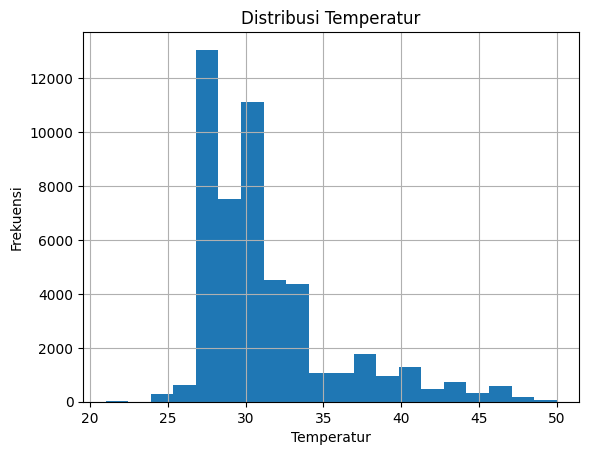

In [ ]:
df['temp'].hist(bins=20)
plt.xlabel('Temperatur')
plt.ylabel('Frekuensi')
plt.title('Distribusi Temperatur')
plt.show()

Histogram di atas menunjukkan bahwa data tidak berdistribusi secara normal. Ciri distribusi data normal adalah memiliki bentuk lonceng. Data di atas termasuk right skewed atau positive skew.

# **Outlier**

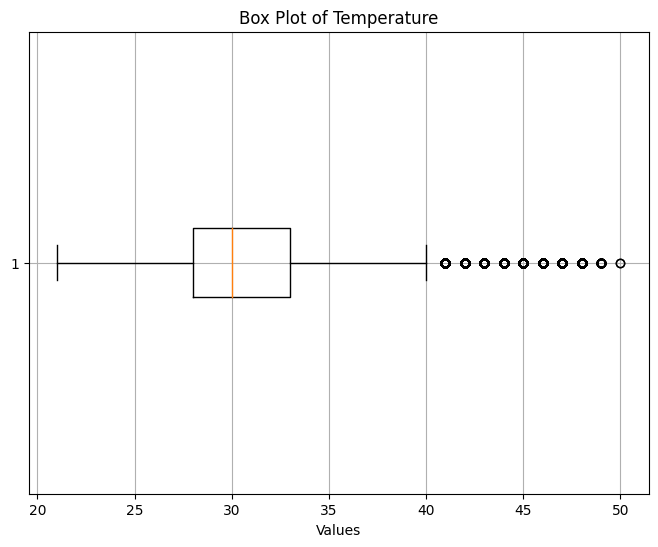

In [ ]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['temp'], vert=False)  #vert=False berfungsi untuk membuat boxplot tampil secara horizontal
plt.title('Box Plot of Temperature')
plt.xlabel('Values')
plt.grid(True)
plt.show()

Dapat dilihat pada boxplot diatas bahwa masih terdapat titik-titik data yang berada di luar caps yang menandakan masih terdapat outlier

# **Outside VS Inside**

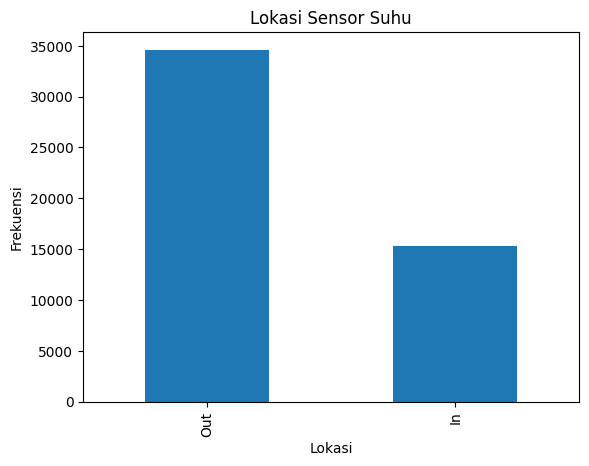

In [ ]:
df['place'].value_counts().plot(kind='bar')
plt.xlabel('Lokasi')
plt.ylabel('Frekuensi')
plt.title('Lokasi Sensor Suhu')
plt.show()

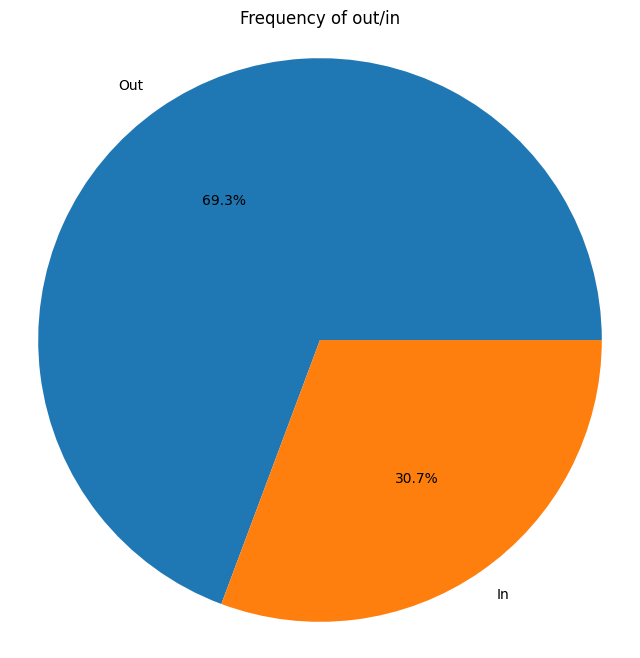

In [ ]:
value_counts = df['place'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=0)
plt.axis('equal')
plt.title('Frequency of out/in')

plt.show()

Dengan menggunakan barplot diatas didapatkan kesimpulan bahwa data lebih banyak diperoleh dari sensor yang berada di luar ruangan

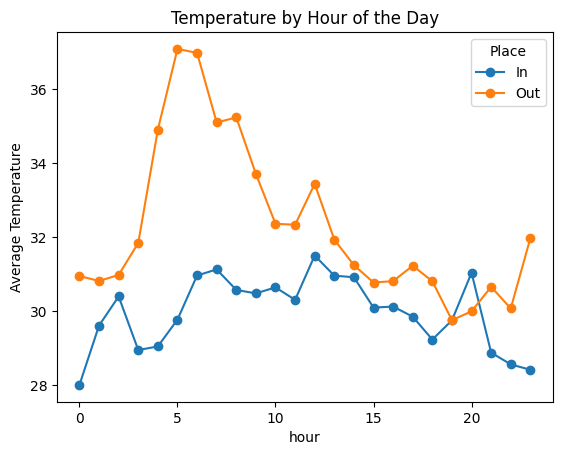

In [ ]:
df_grouped = df.groupby(['hour', 'place'])['temp'].mean().unstack()

# Plot the two line charts on the same graph
df_grouped.plot(kind='line', marker='o')

# Add labels and title
plt.ylabel('Average Temperature')
plt.title('Temperature by Hour of the Day')
plt.legend(title='Place')  # Add legend with 'Place' as the title

# Show the plot
plt.show()

Dengan menggunakan visualisasi diatas dapat lebih ditegaskan bahwa suhu di luar ruangan secara general lebih tinggi dibandingkan dengan suhu di dalam ruangan.

# **Temperature trend**

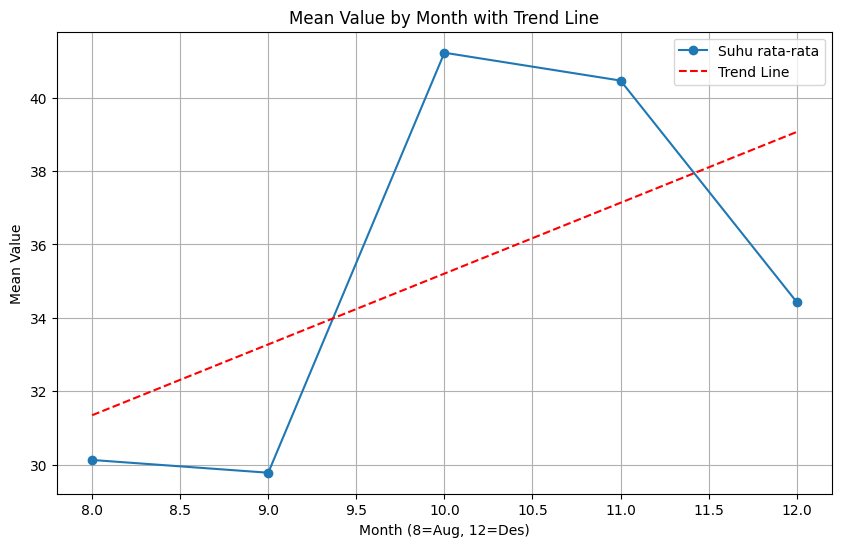

In [ ]:
weekday_means = df.groupby('month')['temp'].mean()

# Plotting the line chart
plt.figure(figsize=(10, 6))
plt.plot(weekday_means.index, weekday_means.values, marker='o', label='Suhu rata-rata')

# Calculating and plotting trend line
z = np.polyfit(weekday_means.index, weekday_means.values, 1) #Koefisien polinomial
p = np.poly1d(z) #Objek Polinomial dari koefisien yang telah dibuat sebelumnya
plt.plot(weekday_means.index, p(weekday_means.index), "r--", label="Trend Line")

# Adding labels and title
plt.xlabel('Month (8=Aug, 12=Des)')
plt.ylabel('Mean Value')
plt.title('Mean Value by Month with Trend Line')
plt.legend()


# Displaying the plot
plt.grid(True)
plt.show()

# **Data Correlation**

<ipython-input-155-9d8e000e1bee>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df.corr()


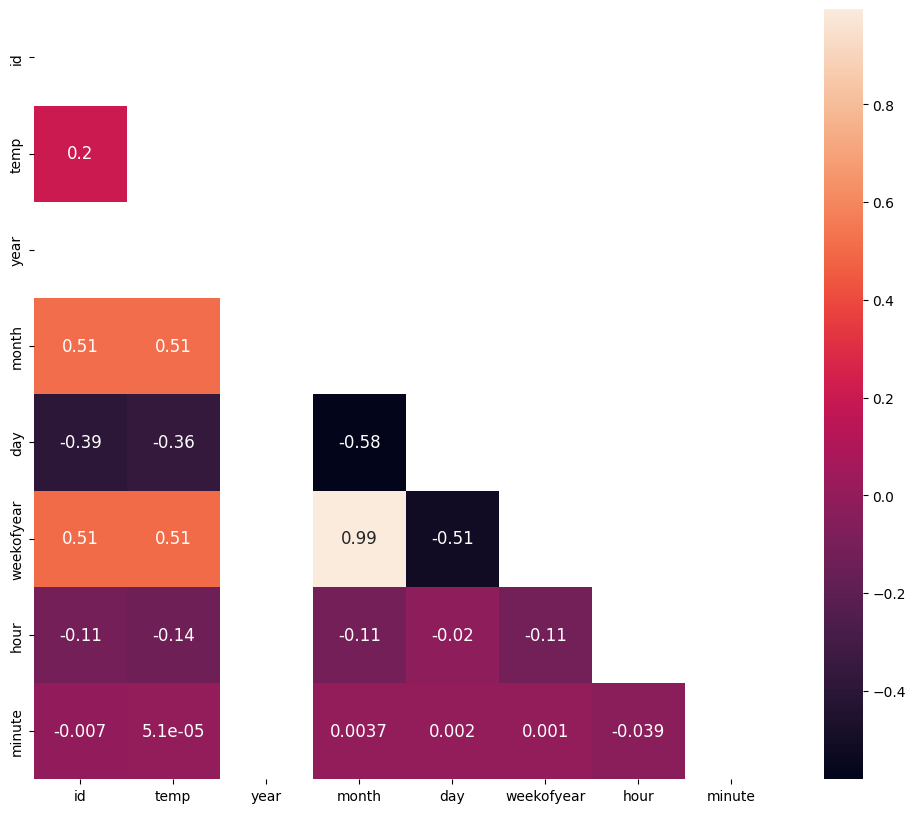

In [ ]:
df_corr = df.corr()

plt.figure(figsize=(12,10))
sns.heatmap(df_corr, annot=True,annot_kws={'size':12},mask=np.triu(df_corr))

plt.show()

Dapat dilihat bahwa data temperaur memiliki korelasi atau hubungan yang cukup tinggi dengan week of year dan month.